# Proyecto: Análisis exploratorio de datos para decisiones comerciales

#### Francisca Rojas González

## Lección 1: ANÁLISIS EXPLORATORIO DE DATOS
Objetivo: Comprender el propósito del EDA y diferenciarlo del análisis inicial.

Tareas a desarrollar:
- Generar un dataset para poder analizarlo (compras, visitas, montos, devoluciones, reseñas)
- Distinguir variables cuantitativas y categóricas
- Detectar valores faltantes o inconsistencias (IDA)
- Documentar primeros hallazgos

In [1]:
# Importar librerías y funciones necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# ------- DATOS FICTICIOS ------- #

# Configuración inicial, semilla números aleatorios y cantidad
np.random.seed(42)
n = 1000  # cantidad de clientes

# VARIABLES 

# Datos clientes: género, región, edad (entre 18 y 75)
genero = np.random.choice(["Femenino", "Masculino", "Otro"], size=n, p=[0.48, 0.48, 0.04])
region = np.random.choice(["Norte", "Centro", "Sur"], size=n, p=[0.25, 0.5, 0.25])
edad = np.random.normal(loc=38, scale=12, size=n).astype(int)
edad = np.clip(edad, 18, 75)

# Canal de compra
canal = np.random.choice(["Web", "App"], size=n, p=[0.6, 0.4])

# Visitas influenciadas levemente por el Canal 
visitas_mensuales = np.random.poisson(lam=np.where(canal == "App", 18, 10), size=n)

compras = np.random.poisson(lam=3, size=n)

# Monto promedio de compra
monto_promedio = np.random.normal(loc=30000 + edad * 150, scale=12000, size=n)
monto_promedio = np.clip(monto_promedio, 5000, None).astype(int)

# Gasto total 
gasto_total = compras * monto_promedio

# Devoluciones
devoluciones = np.random.binomial(n=2, p=0.15, size=n)

# Satisfacción relación con devoluciones y con la edad
satisfaccion = 4.5 - (devoluciones * 0.8) + (edad * 0.005) + np.random.normal(0, 0.3, n)
satisfaccion = np.round(np.clip(satisfaccion, 1, 5),2)

# ------- CONSTRUCCIÓN DEL DATAFRAME -------- #

df = pd.DataFrame({
    "Edad": edad,
    "Genero": genero,
    "Region": region,
    "Canal": canal,
    "Visitas_Mensuales": visitas_mensuales,
    "Compras": compras,
    "Monto_Promedio": monto_promedio,
    "Gasto_Total": gasto_total,
    "Devoluciones": devoluciones,
    "Satisfaccion": satisfaccion})


# ----- INTRODUCIR "RUIDO" ------ #

# Valores faltantes (NaN)
for col in ["Monto_Promedio", "Satisfaccion"]:
    df.loc[df.sample(frac=0.04).index, col] = np.nan

# Inconsistencias (Edades imposibles y compras negativas)
df.loc[df.sample(3).index, "Edad"] = -5 
df.loc[df.sample(2).index, "Compras"] = -1

# Outliers 
outliers = df.sample(12).index
df.loc[outliers, "Gasto_Total"] *= 6


# ------ EXPORTACIÓN ------- #
df.to_csv("comercioYA_clientes_simulados.csv", index=False, encoding="utf-8-sig")

# Visualizar dataset generado
df

,Edad,Genero,Region,Canal,Visitas_Mensuales,Compras,Monto_Promedio,Gasto_Total,Devoluciones,Satisfaccion
0,27,Femenino,Norte,Web,13,2,43400.0,86800,1,3.82
1,28,Masculino,Centro,App,17,3,42112.0,126336,0,4.66
2,35,Masculino,Sur,App,15,2,45476.0,90952,0,4.66
3,42,Masculino,Centro,Web,9,3,36358.0,109074,0,4.32
4,48,Femenino,Sur,Web,8,4,49612.0,198448,0,4.44
...,...,...,...,...,...,...,...,...,...,...
995,31,Femenino,Centro,App,12,3,40719.0,122157,1,4.29
996,50,Masculino,Sur,App,25,1,35036.0,35036,0,5.00
997,63,Femenino,Norte,Web,9,4,42426.0,169704,1,4.15
998,18,Masculino,Norte,App,19,4,27686.0,110744,0,5.00


In [3]:
# ------ VISUALIZACIÓN RÁPIDA ------- #
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Edad               1000 non-null   int64  
 1   Genero             1000 non-null   object 
 2   Region             1000 non-null   object 
 3   Canal              1000 non-null   object 
 4   Visitas_Mensuales  1000 non-null   int64  
 5   Compras            1000 non-null   int64  
 6   Monto_Promedio     960 non-null    float64
 7   Gasto_Total        1000 non-null   int64  
 8   Devoluciones       1000 non-null   int64  
 9   Satisfaccion       960 non-null    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 78.3+ KB


- Se encuentran dos columnas con valores nulos.
- Se notan 3 columnas con variables categóricas según su tipo, y el resto cuantitativas.

### Tipos de variables

- Edad: Cuantitativa discreta (años cumplidos).
- Visitas Mensuales: Cuantitativa discreta.
- Compras: Cuantitativa discreta.
- Monto Promedio: Cuantitativa continua.
- Gasto Total: Cuantitativa continua.
- Satisfacción: Cuantitativa continua.
- Género: Categórica nominal.
- Región: Categórica nominal.
- Canal: Categórica nominal.

In [4]:
# ------ VISUALIZACIÓN RÁPIDA DE ESTADÍSTICAS BÁSICAS ------- #
df.describe() 

,Edad,Visitas_Mensuales,Compras,Monto_Promedio,Gasto_Total,Devoluciones,Satisfaccion
count,1000.000000,1000.000000,1000.000000,960.000000,1000.000000,1000.000000,960.000000
mean,37.765000,13.146000,2.910000,35876.402083,110297.229000,0.300000,4.419729
std,11.465567,5.573666,1.616946,11932.738014,88060.969459,0.519875,0.482002
min,-5.000000,2.000000,-1.000000,5000.000000,0.000000,0.000000,2.490000
25%,30.000000,9.000000,2.000000,27685.000000,53067.750000,0.000000,4.140000
50%,38.000000,12.000000,3.000000,35890.500000,97732.500000,0.000000,4.530000
75%,46.000000,17.000000,4.000000,44098.000000,149217.000000,1.000000,4.790000
max,75.000000,31.000000,10.000000,78528.000000,945000.000000,2.000000,5.000000


In [5]:
# Ver valores negativos para evaluar cómo trabajarlos
negativos_edad = df[df['Edad'] < 0]
negativos_compras = df[df['Compras'] < 0]

print(negativos_edad)
print(negativos_compras)

     Edad     Genero  Region Canal  Visitas_Mensuales  Compras  \
479    -5  Masculino  Centro   App                 18        4   
530    -5  Masculino  Centro   Web                 11        6   
929    -5   Femenino   Norte   App                 20        1   

     Monto_Promedio  Gasto_Total  Devoluciones  Satisfaccion  
479         30641.0       122564             1          4.09  
530         48007.0       288042             1          4.24  
929         22952.0        22952             0          4.62  
     Edad     Genero Region Canal  Visitas_Mensuales  Compras  Monto_Promedio  \
838    18  Masculino    Sur   App                 17       -1         12874.0   
858    47  Masculino    Sur   App                 14       -1         40800.0   

     Gasto_Total  Devoluciones  Satisfaccion  
838        38622             0          4.47  
858        81600             0          4.55  


In [6]:
# ------- BUSQUEDA DE DUPLICADOS -------- #
df.duplicated().sum()

np.int64(0)

- Se encuentran valores negativos (visto en mínimos), para edad y compras, lo que es inconsistente. 
- Se vuelven a ver valores faltantes (count menores a 1000) en Monto promedio y Satisfaccion.
- No se encuentran duplicados.
- Se detectan posibles outliers en gastos total (máximo muy alto, desv estandar muy grande).

In [7]:
# ------ LIMPIEZA DE INCONSISTENCIAS Y NULOS ------- #

# Copia de seguridad
df_limpio = df.copy()

# Identificar y reemplazar edades inconsistentes (valores negativos) por la media
# Calcular la media solo de los valores válidos primero (sin negativos)
media_edad = int(df_limpio[df_limpio['Edad'] >= 0]['Edad'].mean())
df_limpio.loc[df_limpio['Edad'] < 0, 'Edad'] = media_edad

# Identificar y reemplazar compras inconsistentes (valores negativos) por la mediana
# Calcular la mediana solo de los valores válidos (sin negativos)
mediana_compras = df_limpio[df_limpio['Compras'] >= 0]['Compras'].median()
df_limpio.loc[df_limpio['Compras'] < 0, 'Compras'] = mediana_compras

# Imputar faltantes con la mediana para no perder datos
df_limpio['Monto_Promedio'] = df_limpio['Monto_Promedio'].fillna(df_limpio['Monto_Promedio'].median())
df_limpio['Satisfaccion'] = df_limpio['Satisfaccion'].fillna(df_limpio['Satisfaccion'].median())

In [8]:
# ------- VERIFICAR LIMPIEZA -------- #
print("------ NULOS POR COLUMNA -------")
print(df_limpio.isna().sum())
print("------- EDAD Y COMPRAS MÍNIMA Y MÁXIMA --------")
print(df_limpio[['Edad', 'Compras']].describe().loc[['min', 'max']])

------ NULOS POR COLUMNA -------
Edad                 0
Genero               0
Region               0
Canal                0
Visitas_Mensuales    0
Compras              0
Monto_Promedio       0
Gasto_Total          0
Devoluciones         0
Satisfaccion         0
dtype: int64
------- EDAD Y COMPRAS MÍNIMA Y MÁXIMA --------
     Edad  Compras
min  18.0      0.0
max  75.0     10.0


Se realizó la limpieza de los datos inconsistentes:
- Se imputó datos negativos y nulos:
    - Para edad con la media de los valores válidos (sin negativos)
    - Para compras con la mediana de los valores válidos (sin negativos)
    - Para monto promedio y satisfacción con la mediana

## Lección 2: CONCEPTOS BÁSICOS DE ESTADÍSTICA DESCRIPTIVA
Objetivo: Aplicar conceptos de tendencia central, dispersión y medidas de posición.

Tareas a desarrollar:
- Calcular media, mediana, moda, varianza, desviación estándar
- Determinar cuartiles y percentiles
- Generar histogramas y boxplots
- Identificar valores atípicos y documentar su impacto

In [9]:
# -------- CÁLCULO MEDIDAS DE TENDENCIA CENTRAL Y DISPERSIÓN ---------- #

# Se define función por si es necesaria para próximos usos
def estadisticas_descriptivas(data):
    """
    Calcula medidas de tendencia central y dispersión para variables numéricas.
    """
    # Filtrar solo las columnas numéricas para evitar errores de cálculo
    df_num = data.select_dtypes(include=['number'])
    
    # Construcción de DataFrame de medidas 
    estadisticas = pd.DataFrame({
        'Media': df_num.mean().round(2),
        'Mediana': df_num.median(),
        'Moda': df_num.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        'Varianza': df_num.var().round(2),
        'Std Dev': df_num.std().round(2),
        'Rango': df_num.apply(lambda x: x.max() - x.min())
    })  
    return estadisticas

print("----- MEDIDAS DE TENDENCIA CENTRAL Y DISPERSIÓN -----")
df_resultados = estadisticas_descriptivas(df_limpio)
print(df_resultados)

----- MEDIDAS DE TENDENCIA CENTRAL Y DISPERSIÓN -----
                       Media   Mediana     Moda      Varianza   Std Dev  \
Edad                   37.89     38.00     18.0  1.259500e+02     11.22   
Visitas_Mensuales      13.15     12.00     10.0  3.107000e+01      5.57   
Compras                 2.92      3.00      2.0  2.580000e+00      1.61   
Monto_Promedio      35876.97  35890.50  35890.5  1.366889e+08  11691.40   
Gasto_Total        110297.23  97732.50      0.0  7.754734e+09  88060.97   
Devoluciones            0.30      0.00      0.0  2.700000e-01      0.52   
Satisfaccion            4.42      4.53      5.0  2.200000e-01      0.47   

                       Rango  
Edad                   57.00  
Visitas_Mensuales      29.00  
Compras                10.00  
Monto_Promedio      73528.00  
Gasto_Total        945000.00  
Devoluciones            2.00  
Satisfaccion            2.51  


In [10]:
# -------- CALCULO MEDIDAS POSICIÓN ---------- #

# Calcular cuartiles y percentiles para las columnas numéricas
# Se define función por si es necesaria para próximos usos
def medidas_posicion(data):
    """
    Calcula cuartiles y percentiles estratégicos para variables numéricas.
    """
    # Filtrar solo columnas numéricas 
    df_num = data.select_dtypes(include=['number'])
    
    # Calcular cuartiles y percentiles  
    percentiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    analisis = df_num.quantile(percentiles).transpose().round(2)
    
    # Renombrar columnas para claridad
    analisis.columns = ['P10', 'Q1 (P25)', 'Q2 (P50)', 'Q3 (P75)', 'P90']
    
    return analisis

print("----- MEDIDAS DE POSICIÓN: CUARTILES Y PERCENTILES -----")
df_posicion = medidas_posicion(df_limpio)
print(df_posicion)

----- MEDIDAS DE POSICIÓN: CUARTILES Y PERCENTILES -----
                        P10  Q1 (P25)  Q2 (P50)   Q3 (P75)        P90
Edad                  23.00     30.00     38.00      46.00      52.00
Visitas_Mensuales      7.00      9.00     12.00      17.00      21.00
Compras                1.00      2.00      3.00       4.00       5.00
Monto_Promedio     21113.90  28154.75  35890.50   43903.25   50553.50
Gasto_Total        26726.90  53067.75  97732.50  149217.00  201384.40
Devoluciones           0.00      0.00      0.00       1.00       1.00
Satisfaccion           3.76      4.16      4.53       4.78       4.98


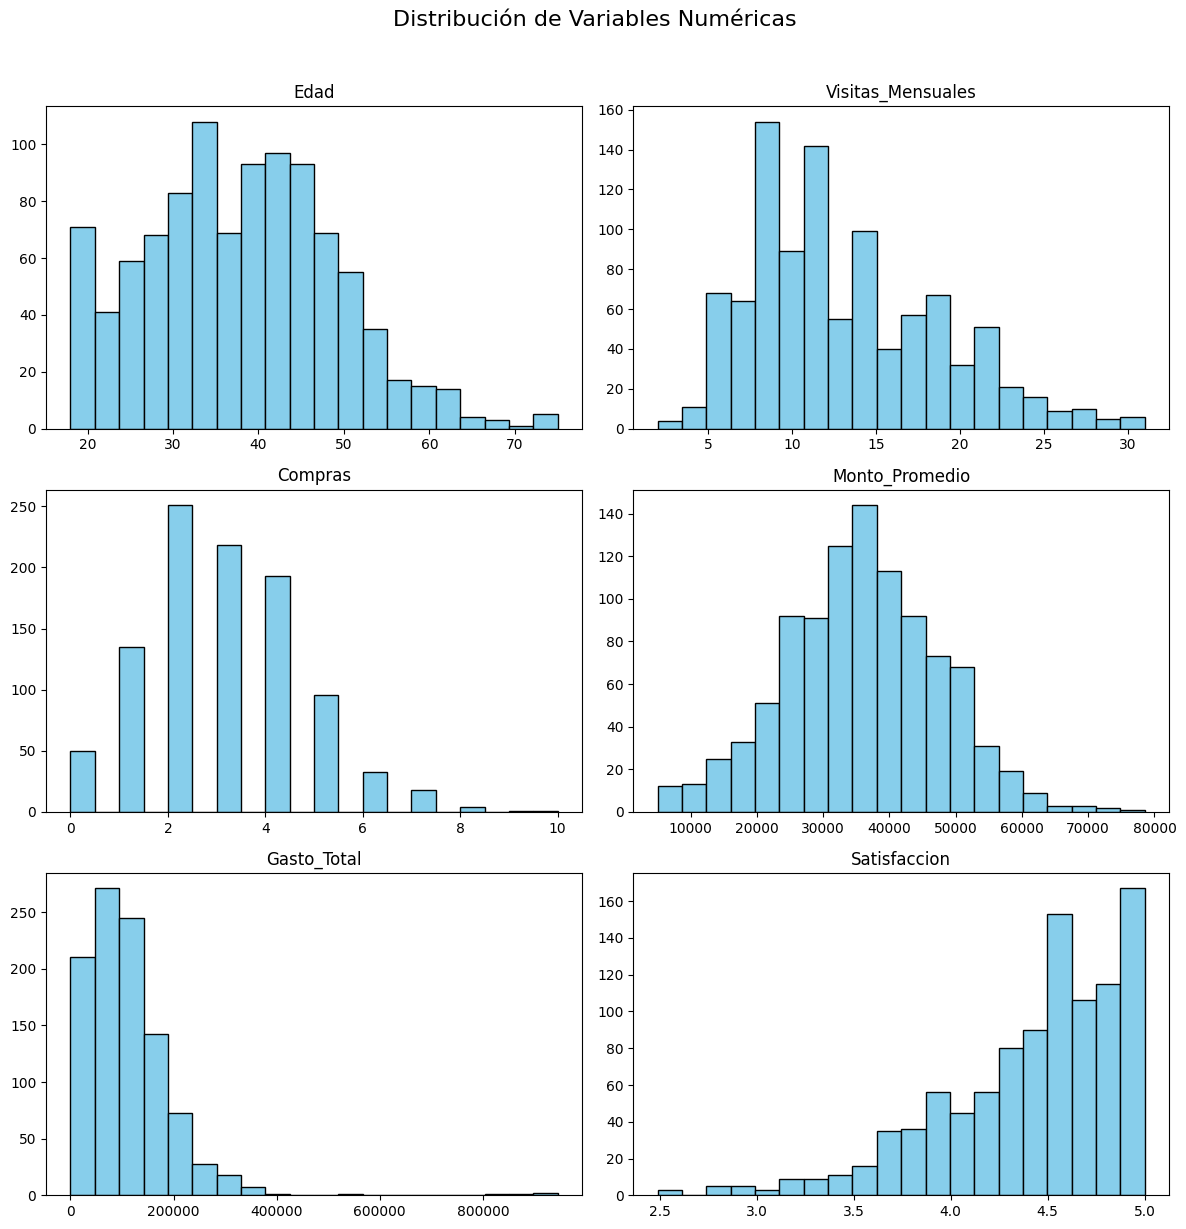

In [11]:
# ----------- HISTOGRAMAS ---------- #

# Seleccionar las variables numéricas clave
cols_num = ['Edad', 'Visitas_Mensuales', 'Compras', 'Monto_Promedio', 'Gasto_Total', 'Satisfaccion']

# Configuración de la figura 
df_limpio[cols_num].hist(bins=20, figsize=(12, 12), color='skyblue', edgecolor='black', grid=False)

# Ajuste estético para que los títulos no se superpongan
plt.suptitle("Distribución de Variables Numéricas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

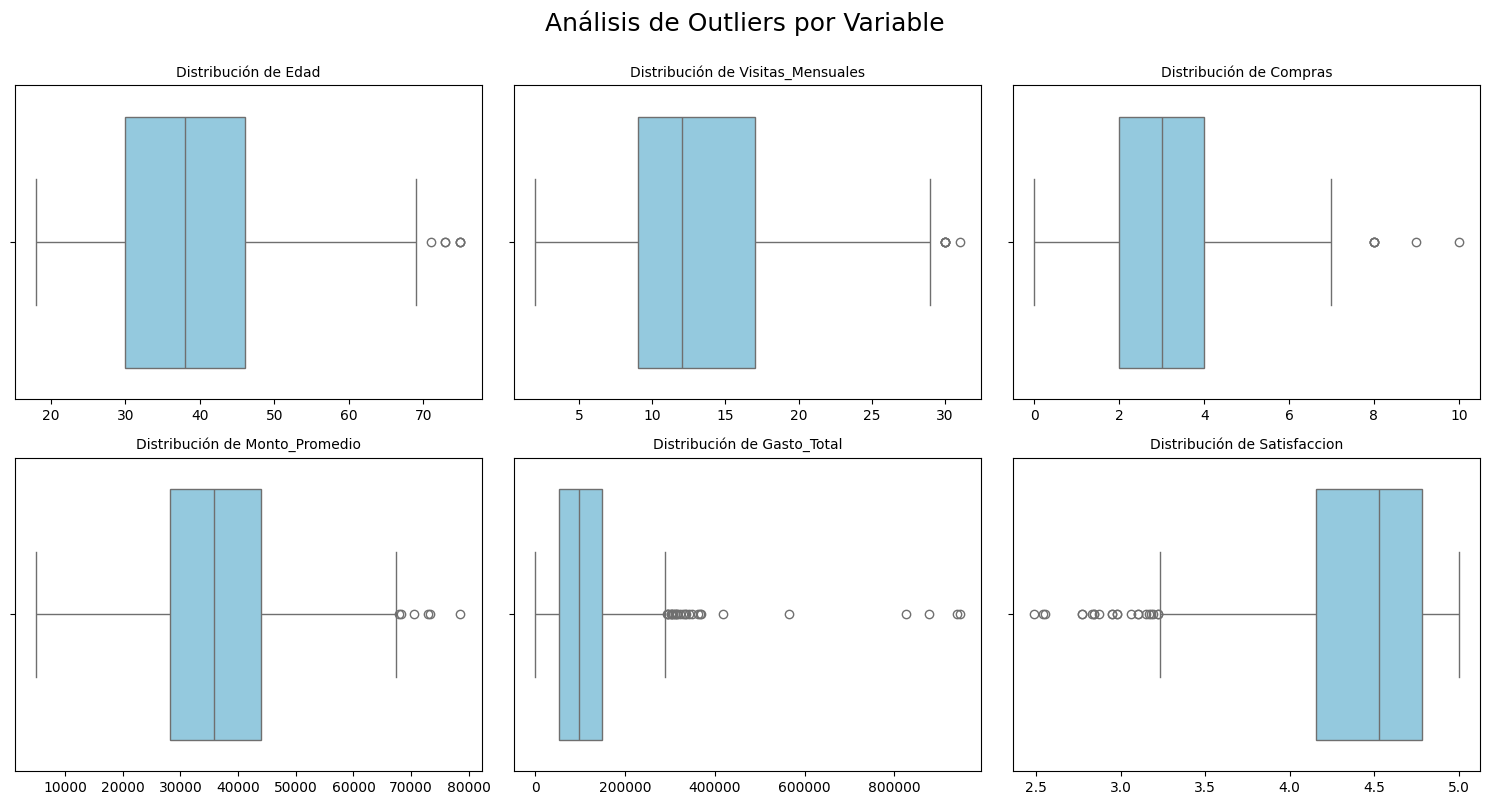

In [12]:
# -------- BOXPLOT Y DETECCIÓN DE OUTLIERS ---------- #

cols_num = ['Edad', 'Visitas_Mensuales', 'Compras', 'Monto_Promedio', 'Gasto_Total', 'Satisfaccion']

# Crear una cuadrícula de 2 filas x 3 columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten() # Aplanar para iterar fácilmente

for i, col in enumerate(cols_num):
    sns.boxplot(data=df_limpio, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribución de {col}', fontsize=10)
    axes[i].set_xlabel('') # Limpiar etiqueta eje X para estética

plt.suptitle("Análisis de Outliers por Variable", fontsize=18, y=1.0)
plt.tight_layout()
plt.show()

Se detectó una presencia marginal de valores atípicos en variables como Edad, Visitas_mensuales, Distribución de compras, Monto_Promedio. Dado que se encuentran próximos a los límites del Rango Intercuartílico ($1.5 \times IQR$) y representan comportamientos de compra verosímiles, se decidió conservarlos para no subestimar la variabilidad natural de los datos.

Por otro lado, para el nivel de satisfacción si bien se encuentran varios bajo el límite inferior, también se decide dejarlos, pues demuestran una representación real de la satisfacción, y considerando que la media y la mediana de esta cantidad están cercanas tampoco están generando gran desvío.

Finalmente para el Gasto_Total, si se detectan valores atípicos que se escapan del límite superior en gran medida, y considerando las medidas de tendencia central y dispersión, se puede ver que afectan la distribución, estándo muy dispersos los datos, también notado en el histograma. Por lo que, se decide trabajar estos valores aplicando Winzorización, para no perder valores, pero aplanar su efecto.

In [13]:
# -------- DETECCIÓN DE OUTLIERS: MÉTODO IQR ---------- #

Q1 = df_limpio['Gasto_Total'].quantile(0.25)
Q3 = df_limpio['Gasto_Total'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

# Identificar outliers: valores < límite inferior o > límite superior
outliers_iqr = df_limpio[(df_limpio["Gasto_Total"] < lim_inf) | (df_limpio["Gasto_Total"] > lim_sup)]

print("Outliers detectados (IQR):", outliers_iqr.shape[0], "\nLímite inferior:", lim_inf, "\nLímite superior:", lim_sup)

Outliers detectados (IQR): 26 
Límite inferior: -91156.125 
Límite superior: 293440.875


Se detectaro valores atípicos (outliers) en la columna de Gasto_Total, se utilizó tanto boxplot para visualizarlos, como método IQR para extraer el total de puntos atípicos, y con esto poder dimensionar si era necesario algún tratamiento particular.
Al no ser tanto puntos y estár la mayoría cercanos límite superior dado por el método IQR, se decidió hacer winzorisación y con esto volver a ver el impacto en el conjunto nuevamente.

In [14]:
# --------- WINSORIZAR --------- #
df_limpio['Gasto_Total_W'] = df_limpio['Gasto_Total'].clip(upper=lim_sup)

-------- GASTOS CON OUTLIERS --------
                 Media  Mediana  Moda      Varianza   Std Dev   Rango
Gasto_Total  110297.23  97732.5     0  7.754734e+09  88060.97  945000 
Tamaño: 1000


-------- GASTOS SIN OUTLIERS --------
                 Media  Mediana  Moda      Varianza   Std Dev   Rango
Gasto_Total  101911.27  95334.0     0  4.085237e+09  63915.86  288444 
Tamaño: 974


-------- GASTOS WINSORIZADO --------
                   Media  Mediana  Moda      Varianza   Std Dev       Rango
Gasto_Total_W  106891.04  97732.5   0.0  4.908820e+09  70062.97  293440.875 
Tamaño: 1000




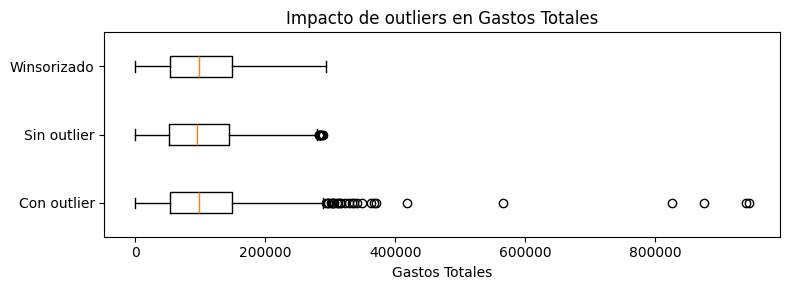

In [15]:
# ----------- DOCUMENTACIÓN IMPACTO OUTLIERS ------------ #

# Crear el DataFrame filtrado (sin outliers), solo con Gasto_total
gastos_sin_outliers = df_limpio.loc[df_limpio['Gasto_Total'] < lim_sup ,'Gasto_Total']

# Transformar a DataFrame para utilizar funciones previas de estadísticas descriptivas
r1 = pd.DataFrame(df_limpio["Gasto_Total"])
r2 = pd.DataFrame(gastos_sin_outliers)
r3 = pd.DataFrame(df_limpio['Gasto_Total_W'])

print("-------- GASTOS CON OUTLIERS --------")
print(estadisticas_descriptivas(r1), "\nTamaño:", len(r1))
print(f"{''*1}\n")
print("-------- GASTOS SIN OUTLIERS --------")
print(estadisticas_descriptivas(r2), "\nTamaño:", len(r2))
print(f"{''*1}\n")
print("-------- GASTOS WINSORIZADO --------")
print(estadisticas_descriptivas(r3), "\nTamaño:", len(r3))
print(f"{''*1}\n")

# Gráfica (boxplot comparativo)
plt.figure(figsize=(8, 3))
plt.boxplot([r1["Gasto_Total"], r2["Gasto_Total"], r3["Gasto_Total_W"]], vert=False, tick_labels=["Con outlier", "Sin outlier", "Winsorizado"])
plt.title("Impacto de outliers en Gastos Totales")
plt.xlabel("Gastos Totales")
plt.tight_layout()
plt.show()

Aquí se hizo la comparación del impacto que tienen los puntos atípicos en la columna Gastos_Totales, donde se aplicaron 3 casos:
- El conjunto inicial de datos sin intervenir
- El conjunto sin los outliers iniciales detectados
- El conjunto con outliers winsorizados
  
Dado esta comparación se puede notar que con la winsorización los valores de dispersión se regulan bastante, hacercándose a los obtenidos son outliers, pero sin quitar peso a los gatos más altos, además de mantener todos los datos evitando sesgos por pérdida de información, deja la mediana intacta y la media más centrada.

Finalmente se decide mantener esta columna de winsorizado pues es más representativo en caso de modelado predictivo. Así se mantiene el tamaño de muestra original ($N=1000$), mientras estabiliza la desviación estándar y la dispersión en general. Esto garantiza que las proyecciones de ingresos no se vean distorsionadas por compras excepcionales que no representan el comportamiento recurrente del mercado.

## Lección 3: CORRELACIÓN
Objetivo: Detectar y cuantificar relaciones entre variables numéricas

Tareas a desarrollar:
- Construir scatterplots y matrices de correlación
- Calcular el coeficiente de Pearson (R)
- Detectar correlaciones espurias y justificar
- Documentar visual y estadísticamente las asociaciones encontradas

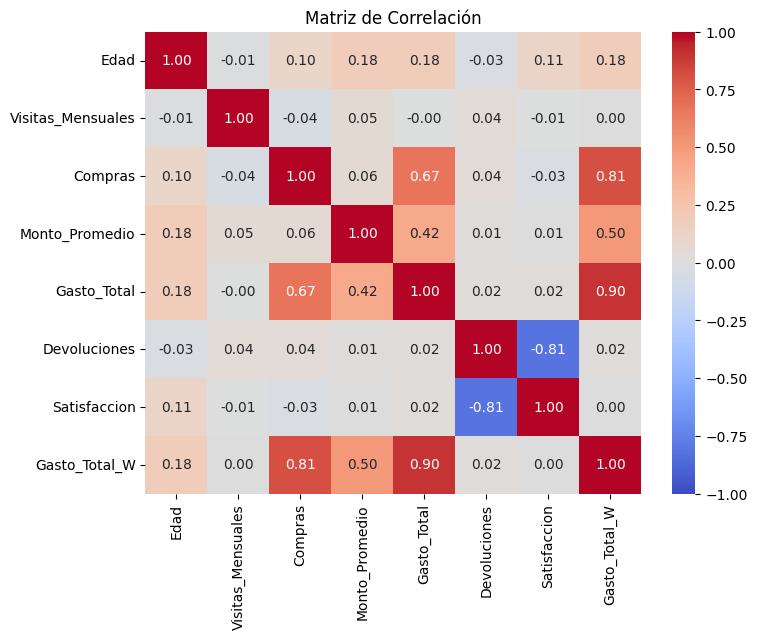

In [16]:
# ------- CORRELACIONES EN MATRIZ COMO MAPA DE CALOR --------- #

# Matriz de Correlación: Coeficiente de Pearson (R)
corr_matrix = df_limpio.select_dtypes(include=[np.number]).corr()

# Visualización con Heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1 )
plt.title('Matriz de Correlación')
plt.show()

### Correlaciones espurias y asociaciones encontradas
No se detectan correlaciones espurias, sino más bien correlaciones matemáticas directas y relaciones de negocio esperadas
* Observación: en el gráfico destaca Gasto_Total con Gasto_Total_W, pero sabemos que es dado la naturaleza de ambos, no hay relación real.

Entre las relaciones encontradas se destacan:

1. Correlación Gasto_Total vs. Compras ($0.67$), y Monto_Promedio ($0.41$):

Es una correlación alta y lógica, ya que $Gasto = Compras \times Monto$. No es espuria porque hay una relación causal directa.

Gasto_Total_W vs. Compras ($0.80$): Al "limpiar" los outliers (Winsorización), la relación se vuelve mucho más fuerte y clara. Es decir, que al tratar los datos atípicos, el volumen de compras explica mejor el gasto total.

2. La relación más fuerte encontrada fue, Satisfacción y Devoluciones ($-0.81$):

Esta es una correlación negativa muy fuerte. Nos dice que a medida que aumentan las devoluciones, la satisfacción cae drásticamente.

3. Detección de correlaciones débiles (casi nulas) Visitas_Mensuales vs. Gasto_Total ($-0.003$):

Que alguien visite mucho la web no significa que gaste más. Esto sugiere que podría haber muchos visitantes que no concretan la compra, o que el tráfico de la App/Web no está bien optimizado para la conversión.

4. Edad vs. Satisfacción ($0.11$):

Es una relación muy débil. No se podría decir con seguridad que los mayores están más felices que los jóvenes basándose solo en esto.

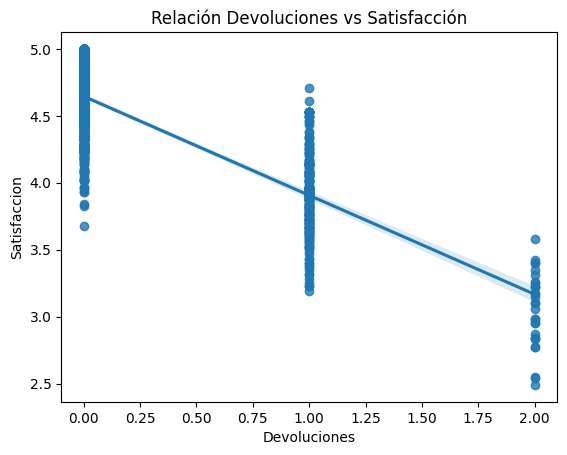

In [17]:
# --------- RELACIONES ENCONTRADAS ENTRE SATISFACCIÓN Y DEVOLUCIONES --------- #

# Scatterplot para visualizar relación encontrada
sns.regplot(data=df_limpio, x='Devoluciones', y='Satisfaccion')
plt.title('Relación Devoluciones vs Satisfacción')
plt.show()

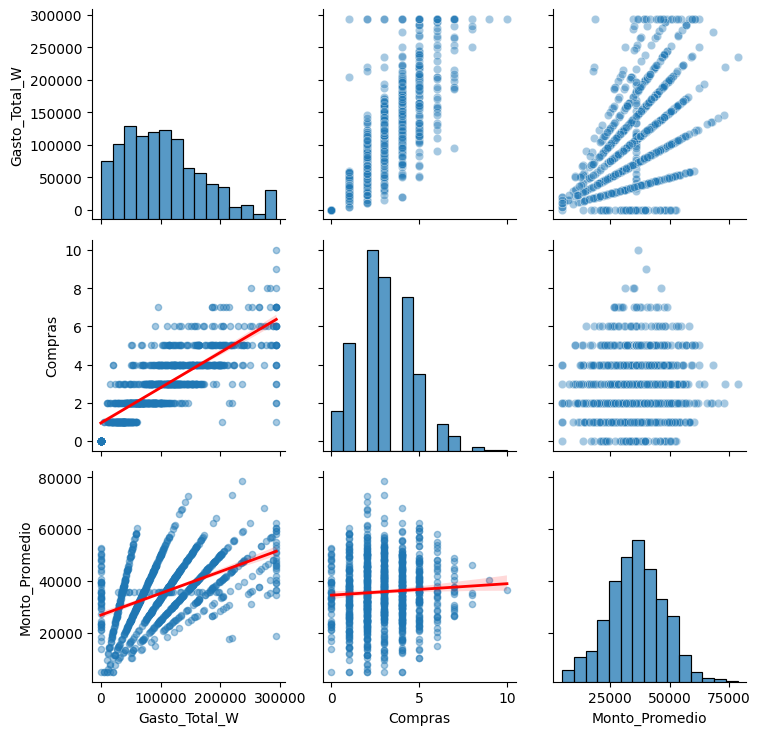

In [18]:
# --------- RELACIONES ENCONTRADAS CON GASTO_TOTAL_W --------- #

g = sns.PairGrid(df_limpio, vars=["Gasto_Total_W", "Compras", "Monto_Promedio"])
g.map_upper(sns.scatterplot, alpha=0.4)
g.map_diag(sns.histplot, bins=15)
g.map_lower(sns.regplot, scatter_kws={"alpha":0.4, "s": 20}, ci=95, line_kws={"lw": 2,'color':'red'})
plt.show()

## Lección 4: REGRESIONES LINEALES
Objetivo: Implementar un modelo de regresión simple y múltiple para explicar variables dependientes.

Tareas a desarrollar:
- Aplicar modelos con statsmodels
- Calcular R2, MSE, MAE
- Evaluar significancia de predictores
- Interpretar coeficientes e inferencias básicas
- Visualizar la regresión con Seaborn

In [19]:
# ---------- MÉTRICAS DE EVALUACIÓN ----------- #

# Se define una función para evaluar modelos
def evaluar_modelo_regresion(modelo, y_real):
    """
    Calcula y muestra las métricas de error y ajuste para un modelo OLS.
    """
    # Obtener predicciones
    y_pred = modelo.fittedvalues
    
    # Calcular métricas de error
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    
    # Extraer métricas de ajuste del modelo
    r2 = modelo.rsquared
    r2_adj = modelo.rsquared_adj
    
    # Impresión 
    print(f"\n{'='*40}")
    print("   MÉTRICAS DE EVALUACIÓN DEL MODELO")
    print(f"{'='*40}")
    print(f"R²:                       {r2:.4f}")
    print(f"R² Ajustado:              {r2_adj:.4f}")
    print(f"{'-'*40}")
    print(f"MAE (Error Medio Abs.):   {mae:.4f}")
    print(f"MSE (Error Cuadrático):   {mse:.4f}")
    print(f"RMSE (Raíz Error Cuad.):  {rmse:.4f}")
    print(f"{'='*40}\n")
    
    # Devolver un diccionario por si se necesitan los valores a posteriori
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2, "R2_adj": r2_adj}

In [20]:
# ------- APLICAR REGRESIÓN LINEAL SIMPLE: SATISFACCIÓN VS DEVOLUCIONES -------- #

# Definir variables 
X = df_limpio['Devoluciones']
X = sm.add_constant(X)  # Añadir intercepto 
y = df_limpio['Satisfaccion'] # Variable dependiente 

# Ajustar el modelo
modelo_sat = sm.OLS(y, X).fit()

# Mostrar resultados
print(f"\n{'='*80}")
print("   RESULTADOS DEL MODELO DE REGRESIÓN SIMPLE: SATISFACCIÓN VS DEVOLUCIONES ")
print(f"{'='*80}\n")
print(modelo_sat.summary())

# Aplicar la función de métricas de error
metricas_sat = evaluar_modelo_regresion(modelo_sat, df_limpio['Satisfaccion'])


   RESULTADOS DEL MODELO DE REGRESIÓN SIMPLE: SATISFACCIÓN VS DEVOLUCIONES 

                            OLS Regression Results                            
Dep. Variable:           Satisfaccion   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     1946.
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          1.09e-236
Time:                        16:27:46   Log-Likelihood:                -128.31
No. Observations:                1000   AIC:                             260.6
Df Residuals:                     998   BIC:                             270.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

### Lectura de parámetros

En primera instancia se opta por hacer esta regresión dado las relaciones encontradas en las correlaciones.

- R² = 0.6610
- R² ajustado = 0.6607

Esto dice que el modelo explica alrededor del 66.1 % de la variabilidad de la satisfacción de los clientes. El otro 33.9% se debe a otros factores no considerados aquí.


La ecuación del modelo

$$ satisfaccion = 4.6459 - 0.7393 * devoluciones $$

Interpretación:

* Por cada devolución, la satisfacción disminuye en 0.74 puntos. Con un error de 0.017, es muy pequeño en relación con el valor del coeficiente mismo.
* Sin devoluciones la satisfacción sería aprox 4.6459, con un error de 0.010, muy bajo.
* Un p-values = 0.000 para ambas, lo que es significativo.
* t = -44, la variable es importante.


F-statistic alto (1946) y p ≈ 0 lo que indica que el modelo completo es relevante y significativo.

MAE (Error Medio Abs.):   0.2239
- En promedio, el modelo se equivoca en 0.2239 puntos sobre la satisfacción. Muy bajo.

MSE (Error Cuadrático):   0.0757

RMSE (Raíz Error Cuad.):  0.2751
- En promedio, el modelo se equivoca en 0.2751 puntos sobre la satisfacción. Muy bajo.

**Conclusión final:**
El modelo de regresión simple demuestra que las devoluciones son un predictor crítico y negativo de la experiencia del cliente. Con una capacidad explicativa del 66% ($R^2 = 0.661$), el análisis confirma que por cada evento de devolución, la satisfacción del usuario cae drásticamente en 0.74 puntos. Dada la alta significancia estadística ($p < 0.001$) y el bajo error promedio ($RMSE = 0.27$), el modelo es una herramienta robusta para la toma de decisiones. 

La recomendación estratégica es priorizar la reducción de devoluciones o la optimización del proceso de logística inversa, ya que este factor es el principal detractor de la lealtad del cliente identificado hasta el momento.

In [21]:
# ------- APLICAR REGRESIÓN LINEAL MÚLTIPLE SATISFACCIÓN -------- #

# Definir variables
X = df_limpio[['Edad', 'Devoluciones']]
X = sm.add_constant(X) # Añadir intercepto
y = df_limpio['Satisfaccion']

# Ajustar modelo con statsmodels
modelo_sat_mul = sm.OLS(y, X).fit()

# Evaluación de significancia y R2 
print(modelo_sat_mul.summary())

metricas_sat_mul = evaluar_modelo_regresion(modelo_sat_mul, df_limpio['Satisfaccion'])

                            OLS Regression Results                            
Dep. Variable:           Satisfaccion   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1007.
Date:                Sat, 14 Feb 2026   Prob (F-statistic):          4.69e-240
Time:                        16:27:46   Log-Likelihood:                -116.51
No. Observations:                1000   AIC:                             239.0
Df Residuals:                     997   BIC:                             253.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.5033      0.031    145.783   

### Lectura de parámetros

Se aplica este modelo al notar una leve correlación entre edad y satisfacción, por lo que, se decide probar si agregando esta variable, el modelo se ajusta mejor a los datos.

- R² = 0.6689
- R² ajustado = 0.6683

Esto dice que el modelo explica alrededor del 66,9 % de la variabilidad de la satisfacción de los clientes. El otro 33.1% se debe a otros factores no considerados aquí.


La ecuación del modelo

$$ satisfaccion = 4.5033 - 0.7369 * devoluciones + 0.0037 * edad $$

Interpretación:

* Por cada devolución, la satisfacción disminuye en 0.74 puntos. Con un error de 0.017, es muy pequeño en relación con el valor del coeficiente mismo.
* Por cada año de la edad, la satisfacción aumenta en 0.0037 puntos. Con un error de 0.001, es pequeño en relación con el valor del coeficiente mismo.
* Un p-values = 0.000 para ambas variables, lo que las hace significativas.
* t = -44 para devolucion y t = 4.879 para edad, lo que indica que las devoluciones son más fuertes en el modelo.


F-statistic alto (1007) y p ≈ 0 lo que indica que el modelo completo es relevante y significativo.

MAE (Error Medio Abs.):   0.2209
- En promedio, el modelo se equivoca en 0.2209 puntos sobre la satisfacción. Muy poco.

MSE (Error Cuadrático):   0.0739

RMSE (Raíz Error Cuad.):  0.2719
- En promedio, el modelo se equivoca en 0.2719 puntos sobre la satisfacción. Muy bajo.

**Conclusión final:**
Al integrar la variable Edad al modelo, se confirma que la satisfacción no depende únicamente del servicio (devoluciones), sino también de un componente demográfico. Aunque el impacto de las devoluciones se mantiene como el principal detractor ($-0.74$), se observa que la satisfacción tiende a aumentar ligeramente con la edad del cliente ($+0.004$ por año).Este modelo reduce el error global de predicción ($RMSE = 0.2719$) y presenta una alta significancia ($p < 0.001$), permitiendo entender que los clientes más jóvenes podrían ser más sensibles o críticos ante la experiencia de compra que los clientes de mayor edad.

P-valor Shapiro (Simple): 0.0000
P-valor Shapiro (Múltiple): 0.0000


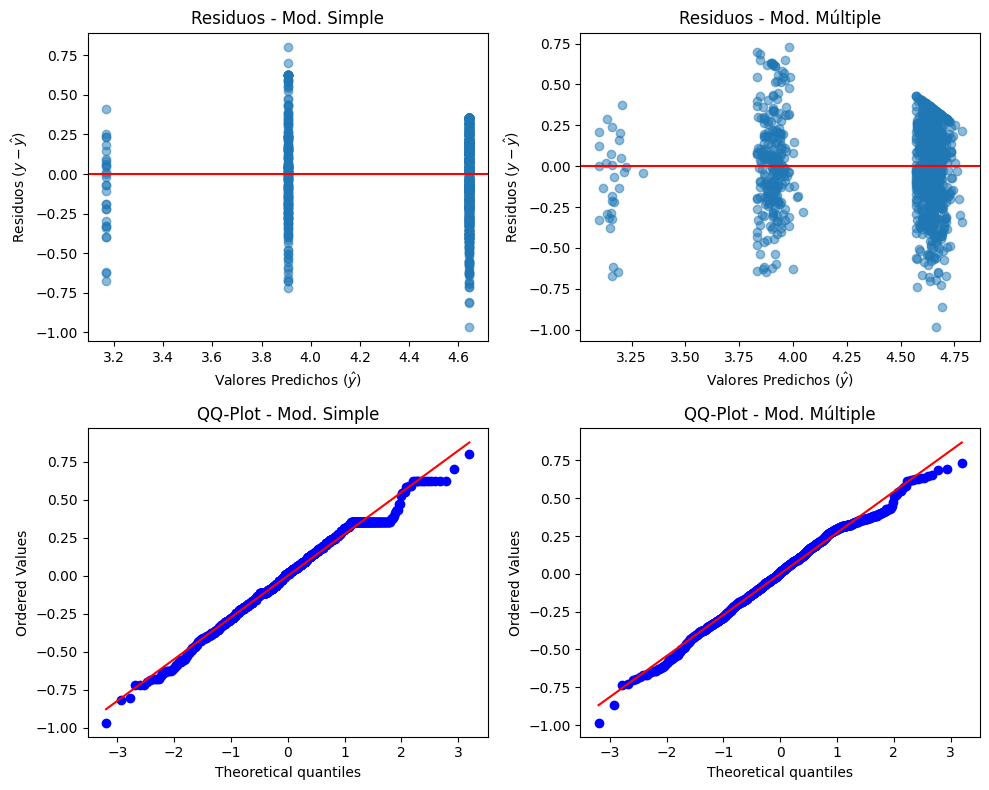

In [22]:
# -------- VERIFICACIÓN DE HOMOCEDASTICIDAD Y NORMALIDAD DE ERROR --------- #

modelos = [("Simple", modelo_sat), ("Múltiple", modelo_sat_mul)]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, (nombre, mod) in enumerate(modelos):
    res = mod.resid
    # Scatter de Residuos (Homocedasticidad)
    axes[0, i].scatter(mod.fittedvalues, res, alpha=0.5)
    axes[0, i].axhline(0, color="red", linestyle="-")
    axes[0, i].set_title(f"Residuos - Mod. {nombre}")
    axes[0, i].set_xlabel("Valores Predichos ($\hat{y}$)")
    axes[0, i].set_ylabel("Residuos ($y - \hat{y}$)")
    
    # QQ-Plot (Normalidad visual)
    stats.probplot(res, dist="norm", plot=axes[1, i])
    axes[1, i].set_title(f"QQ-Plot - Mod. {nombre}")
    
    # Test de Shapiro-Wilk (Normalidad estadística)
    p_val = stats.shapiro(res).pvalue
    print(f"P-valor Shapiro ({nombre}): {p_val:.4f}")

plt.tight_layout()
plt.show()

- Se pueden notar que los datos no son una "nube" totalmente aleatoria, sino que están organizados en columnas o bandas verticales. Esto ocurre porque la variable Devoluciones es discreta. 

- Los residuos muestran homocedasticidad, ya que la dispersión de los errores se mantiene relativamente constante a lo largo de los diferentes niveles de predicción. Lo que valida la estabilidad de las estimaciones del modelo. En general los residuos se distribuyen de manera equilibrada alrededor de cero (arriba-abajo), lo que indica que los modelo no presentas un sesgo sistemático significativo.

Comparativa de modelos:

- Modelo Simple: Las predicciones están muy limitadas a tres puntos específicos (aprox. 3.2, 3.9 y 4.6). El modelo es muy rígido.
- Modelo Múltiple: Al incluir la Edad, las bandas se "ensanchan" y los puntos empiezan a cubrir más espacio en el eje X.

**"El análisis visual de los residuos confirma el cumplimiento del supuesto de homocedasticidad y normalidad de error. Aunque la naturaleza discreta de las variables genera una distribución en bandas, el Modelo Múltiple demuestra una capacidad superior para capturar la variabilidad de la satisfacción, ofreciendo un rango de predicción más continuo y ajustado a la realidad de los distintos perfiles de clientes"**

In [23]:
# -------- VERIFICACIÓN DE MULTICOLINEALIDAD -------- #
from statsmodels.stats.outliers_influence import variance_inflation_factor

# DefiniR los conjuntos de predictores
# Nota: Es vital incluir la constante (intercepto) ya que statsmodels la usa internamente
X2 = sm.add_constant(df_limpio[['Devoluciones', 'Edad']])

def calcular_vif(X):
    vif_df = pd.DataFrame()
    vif_df["Variable"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

print("\n--- VIF Modelo Múltiple ---")
vif_modelo_2 = calcular_vif(X2)
print(vif_modelo_2)


--- VIF Modelo Múltiple ---
       Variable        VIF
0         const  12.870910
1  Devoluciones   1.000895
2          Edad   1.000895


In [24]:
# --------- CRITERIOS DE INFORMACIÓN PARA COMPARAR COMPLEJIDAD DEL MODELO --------- #
print(f"{'='*30}")
print(" COMPARATIVA DE CRITERIOS ")
print(f"{'='*30}")

print(f"Modelo 1 (Simple):   AIC = {modelo_sat.aic:.2f} | BIC = {modelo_sat.bic:.2f}")
print(f"Modelo 2 (Múltiple): AIC = {modelo_sat_mul.aic:.2f} | BIC = {modelo_sat_mul.bic:.2f}")

# Cálculo de la diferencia
diff_aic = modelo_sat.aic - modelo_sat_mul.aic
print(f"{'-'*30}")
print(f"Diferencia de AIC: {diff_aic:.2f}")

 COMPARATIVA DE CRITERIOS 
Modelo 1 (Simple):   AIC = 260.62 | BIC = 270.43
Modelo 2 (Múltiple): AIC = 239.02 | BIC = 253.75
------------------------------
Diferencia de AIC: 21.59


### Comparativa de Modelos y Validación Estadística

| Parámetro | Modelo 1 (Simple) | Modelo 2 (Múltiple) | Impacto / Significado |
| :--- | :--- | :--- | :--- |
| **Variables** | Devoluciones | Devoluciones + Edad | - |
| **R² Ajustado** | 0.6607 | **0.6683** | Incremento en la capacidad explicativa. |
| **AIC (Akaike)** | 260.62 | **239.02** | Reducción de 21.6 puntos (Mejora sustancial). |
| **BIC (Bayesiano)** | 270.43 | **253.75** | Menor valor confirma un modelo más eficiente. |
| **RMSE** | 0.2751 | **0.2719** | Mayor precisión en la estimación de satisfacción. |
| **VIF (Predictores)** | 1.000 | **1.001** | **Multicolinealidad nula**: Información independiente. |

**Justificación Técnica de la Elección del Modelo Múltiple en este caso:**

1. **Eficiencia de Información:** La **Diferencia de AIC (21.59)** es el hallazgo más robusto. En estadística, una diferencia mayor a 10 puntos indica una superioridad abrumadora del modelo con menor AIC. Esto prueba que la **Edad** añade valor real y no solo ruido.
2. **Validación de Independencia (VIF):** El valor de **VIF (~1.0)** para las variables independientes es ideal. Esto nos asegura que las Devoluciones y la Edad no están correlacionadas entre sí, lo que garantiza que los coeficientes obtenidos (el impacto de -0.74 y +0.004) son estables y confiables.
3. **Optimización del Error:** Aunque el Modelo Simple ya era bueno, el Modelo Múltiple logra el **RMSE** más bajo, lo que minimiza la incertidumbre en las proyecciones de satisfacción.

**Conclusión:** Se adopta el **Modelo Múltiple** como la base analítica, ya que cumple con todos los supuestos de regresión y maximiza la información extraída de los datos.

## Lección 5: ANÁLISIS VISUAL DE DATOS

Objetivo: Representar relaciones complejas y distribuciones mediante Seaborn.

Tareas a desarrollar:
- Crear gráficos de tipo pairplot, violinplot, jointplot y heatmap
- Construir visualizaciones que combinen múltiples variables
- Ajustar parámetros de estilo, colores, tamaños
- Utilizar FacetGrid para segmentar por categorías
- Documentar insights visuales

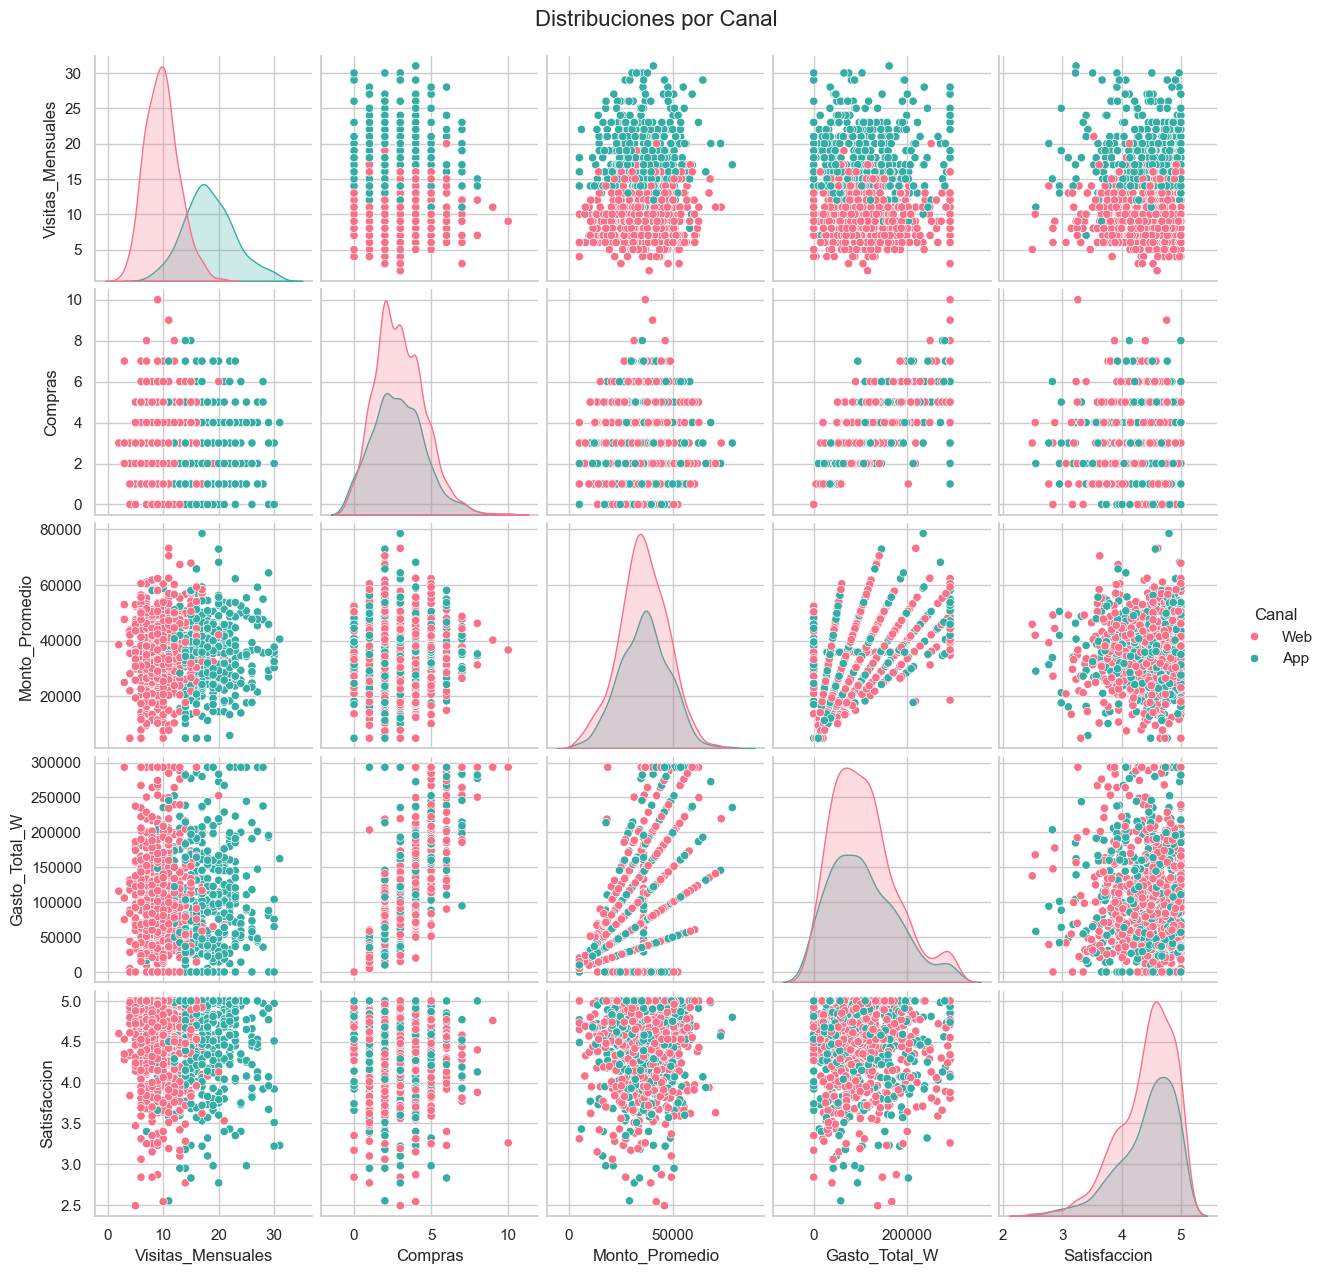

In [25]:
# -------- PAIRPLOT PARA VER DISTRIBUCIONES GLOBALES POR CANAL ---------- #

sns.set_theme(style="whitegrid", context="notebook", palette="deep")

g = sns.pairplot(df_limpio[["Visitas_Mensuales", "Compras", "Monto_Promedio", "Gasto_Total_W", "Satisfaccion", "Canal"]], hue='Canal', palette='husl')
g.fig.suptitle("Distribuciones por Canal",y=1.02, fontsize=16)
plt.show()

Hallazgos:
- Se puede notar que en su mayoría los clientes hacen visitas por el canal Web. Lo que se puede notar en todas las distribuciones.
- Aunque las visitas mensuales son más reiteradas por la App, es decir, quienes ocupan la App hacen más visitas al mes, que quienes hacen la visita mediante la Web.

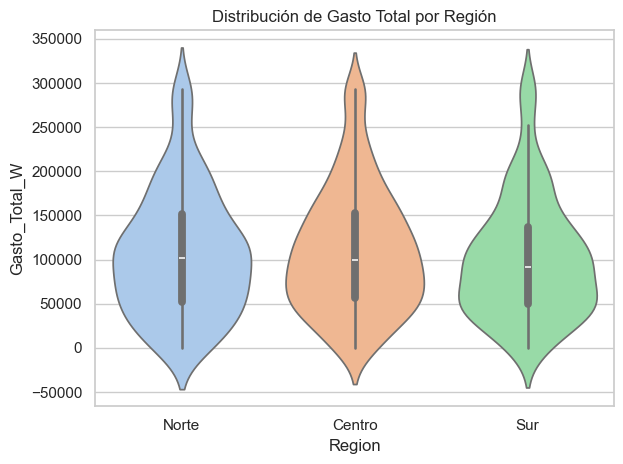

In [26]:
# --------- VIOLINPLOT PARA DISTRIBUCIÓN DE GASTO TOTAL POR REGIÓN ---------- #

sns.set_theme(style="whitegrid", context="notebook")

plt.figure()
sns.violinplot(data=df_limpio, x="Region", y="Gasto_Total_W", inner="box", palette="pastel", hue='Region', legend=False)
plt.title("Distribución de Gasto Total por Región")
plt.tight_layout()
plt.show()

Hallazgos:
- Las distribuciones se ven bastante parecidas por región, a excepción del Sur que se aprecia menos Gastos altos en comparación con las otras dos regiones.

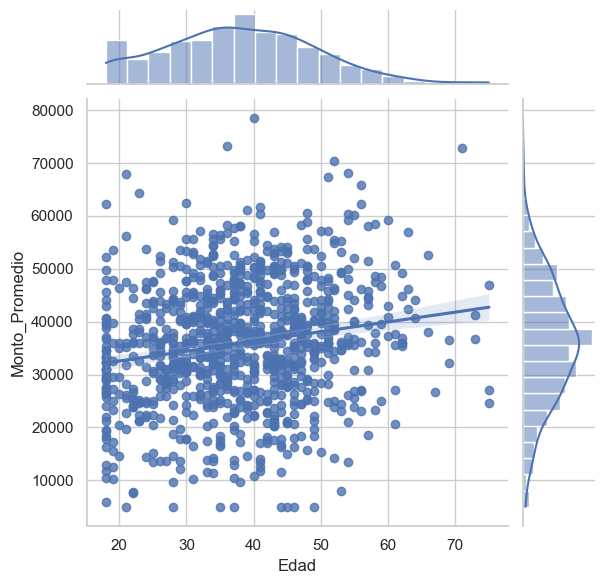

In [27]:
# --------- JOINTPLOT PARA MONTO PROMEDIO POR EDAD --------- #

sns.jointplot(data=df_limpio, x="Edad", y="Monto_Promedio", kind="reg", height=6)
plt.show()

Hallazgos:
- Se puede ver levemente que edades sobre los 60 años, no realizan gastos menores.
- Se puede notar que la mayoría de compradores están bajo los 50 años. 

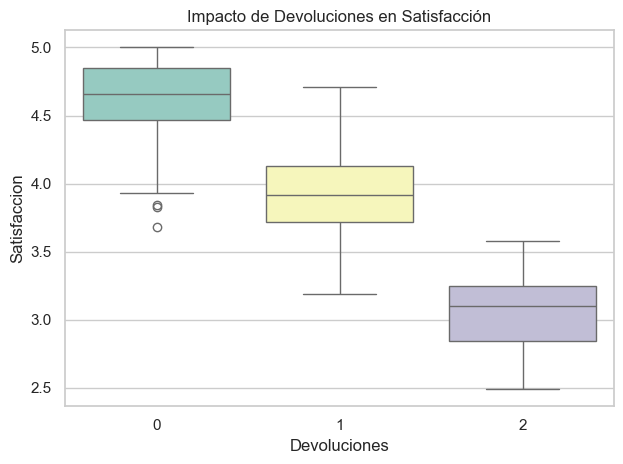

In [28]:
# -------- BOXPLOT DEL IMPACTO DE LAS DEVOLUCIONES EN LA SATISFACCIÓN --------- #

plt.figure()
sns.boxplot(data=df_limpio, x="Devoluciones", y="Satisfaccion", hue='Devoluciones', palette="Set3", legend=False)
plt.title("Impacto de Devoluciones en Satisfacción")
plt.tight_layout()
plt.show()

Hallazgos:
- Se parecia significativamente como una cantidad mayor de devoluciones impacta en la satisfacción de forma negativa y sostenida.

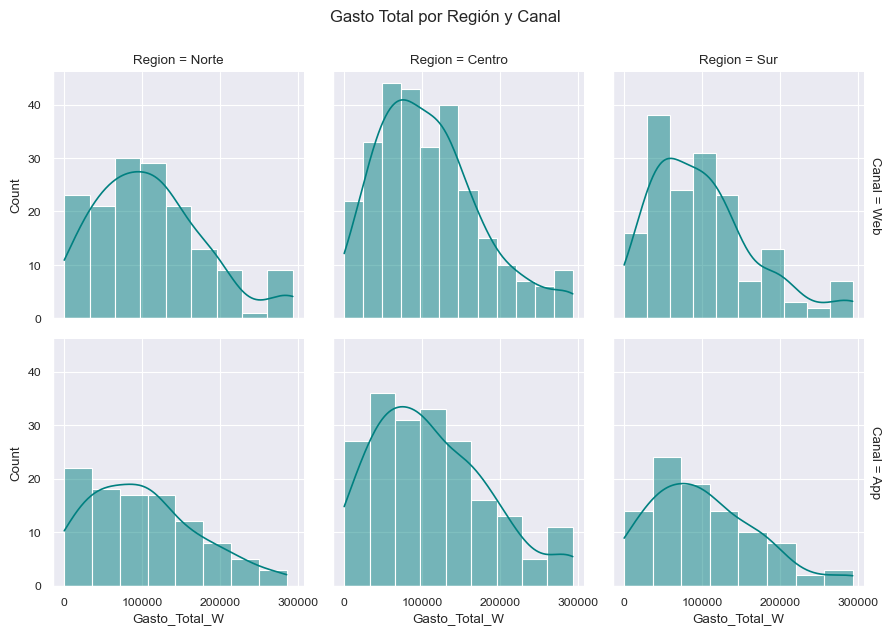

In [29]:
# ------- FACEGRID: SEGMENTACIÓN POR REGIÓN Y CANAL DE COMPRA -------- #
sns.set_theme(style="darkgrid", context="paper")

g = sns.FacetGrid(df_limpio, col="Region", row="Canal", margin_titles=True)
g.map(sns.histplot, "Gasto_Total_W", color="teal",kde=True)
g.fig.suptitle("Gasto Total por Región y Canal",y=1.05, fontsize=12)
plt.savefig("gasto_region_canal.png")
plt.show()

Hallazgos:
- Se aprecia como el canal Web tiene mayor volumen de ventas.
- La región Centro concentra mayor cantidad de ventas.
- En general la forma de la distribución se mantiene para las distintas regiones y canales, solo varían en volumen, pero mantienen forma.

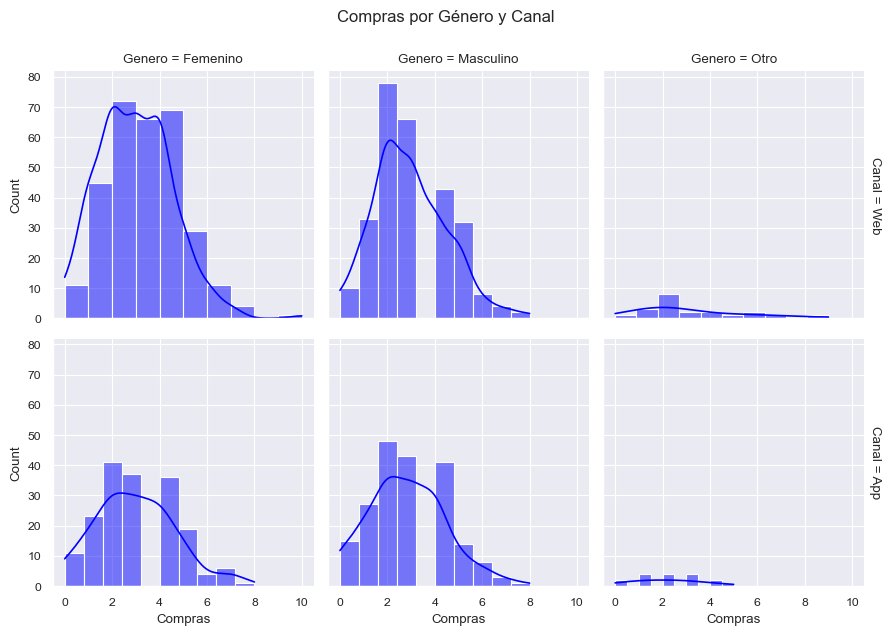

In [30]:
# ------- FACEGRID: SEGMENTACIÓN POR GÉNERO Y CANAL DE COMPRA -------- #
sns.set_theme(style="darkgrid", context="paper")

g = sns.FacetGrid(df_limpio, col="Genero", row="Canal", margin_titles=True)
g.map(sns.histplot, "Compras", color="blue", kde=True, bins=10)
g.fig.suptitle("Compras por Género y Canal",y=1.05, fontsize=12)
plt.show()

Hallazgos:
- Se aprecia que el canal Web tiene mayor volumen de compras independiente del género.

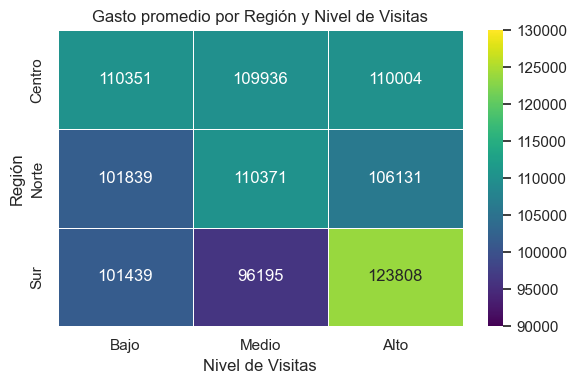

In [31]:
# -------- HEATMAP GASTO PROMEDIO POR REGIÓN Y NIVEL DE VISITAS --------- #

# Crear categorías de visitas (3 categorías)
df_limpio["Nivel_Visitas"] = pd.cut(df_limpio["Visitas_Mensuales"], bins = [1, 10, 20, 32],labels=["Bajo", "Medio", "Alto"])

tabla_visitas = df_limpio.pivot_table(
    values="Gasto_Total_W",
    index="Region",
    columns="Nivel_Visitas",
    aggfunc="mean", observed=True)

sns.set_theme(style="whitegrid", context="notebook")

plt.figure(figsize=(6,4))
sns.heatmap(tabla_visitas, annot=True, fmt=".0f", cmap="viridis", linewidths=0.5,vmin= 90000, vmax=130000)

plt.title("Gasto promedio por Región y Nivel de Visitas")
plt.xlabel("Nivel de Visitas")
plt.ylabel("Región")
plt.tight_layout()
plt.show()

Hallazgos:
- No se aprecia una regularidad en el cambio de nivel, pero se puede notar que en la zona centro el nivel de visita no define el gasto promedio.
- En cambio en la zona sur se pueden notar cambios más drásticos con el nivel de visita y el gasto promedio, donde un nivel de visitas alto, se condice con un mayor gasto, pero a nivel medio se ve una disminución del gasto.
- En la zona norte los gastos al igual que en la zona centro no evidencian un cambio drástico por el nivel de visita, pero si aprecia cierto aumento con el nivel de visita.

## Lección 6: LIBRERÍA MATPLOTLIB
Objetivo: Crear visualizaciones personalizadas y exportables. 

Tareas a desarrollar:
- Crear figuras y subplots
- Personalizar títulos, etiquetas, leyendas, ticks
- Usar anotaciones, límites y formatos de archivo
- Generar una presentación con gráficos finales
- Entregar informe EDA con visualizaciones embebidas

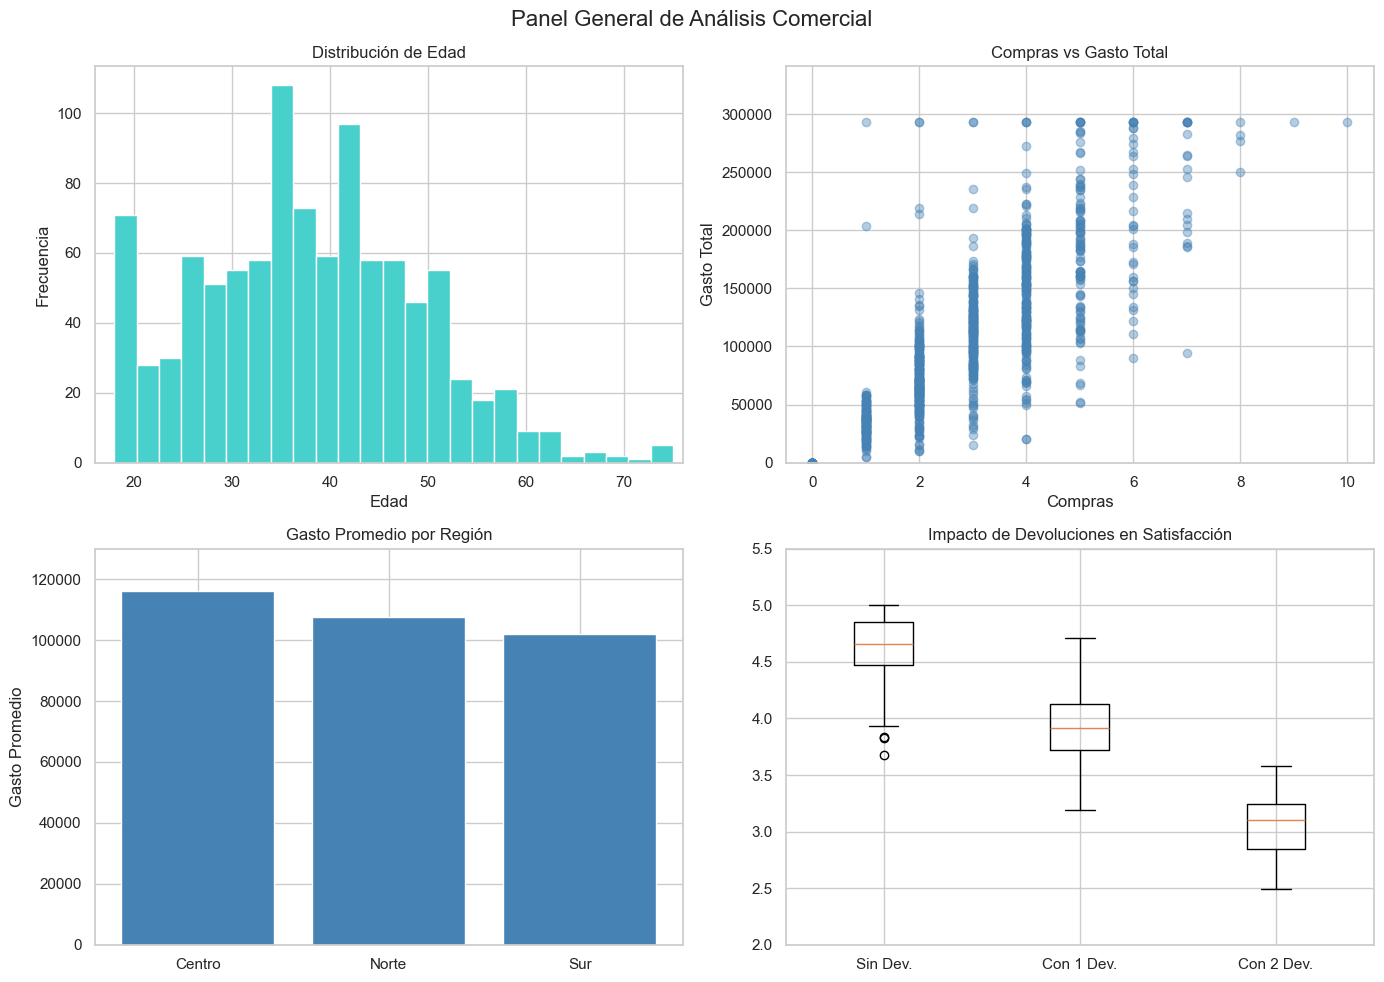

In [32]:
# ------- PANORAMA GENERAL NEGOCIO CON SUBPLOTS-------- #

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Distribución Edad Clientes
axs[0,0].hist(df_limpio["Edad"], bins=25, color="mediumturquoise")
axs[0,0].set_title("Distribución de Edad")
axs[0,0].set_xlabel("Edad")
axs[0,0].set_ylabel("Frecuencia")
axs[0,0].set_xlim(16, 76)

# Compras vs Gasto
axs[0,1].scatter(df_limpio["Compras"], df_limpio["Gasto_Total_W"], alpha=0.4, color="steelblue")
axs[0,1].set_title("Compras vs Gasto Total")
axs[0,1].set_xlabel("Compras")
axs[0,1].set_ylabel("Gasto Total")
axs[0,1].set_ylim(0, df["Gasto_Total"].quantile(0.99))

# Gasto por Región
reg_mean = df_limpio.groupby("Region")["Gasto_Total"].mean()
axs[1,0].bar(reg_mean.index, reg_mean.values, color="steelblue")
axs[1,0].set_title("Gasto Promedio por Región")
axs[1,0].set_ylabel("Gasto Promedio")
axs[1,0].set_ylim(0,130000)

# Satisfacción vs Devoluciones
axs[1,1].boxplot(
    [df_limpio[df_limpio["Devoluciones"]==0]["Satisfaccion"],
     df_limpio[df_limpio["Devoluciones"]==1]["Satisfaccion"],
    df_limpio[df_limpio["Devoluciones"]==2]["Satisfaccion"]],
    tick_labels=["Sin Dev.", "Con 1 Dev.", "Con 2 Dev."])
axs[1,1].set_title("Impacto de Devoluciones en Satisfacción")
axs[1,1].set_ylim(2,5.5)

plt.suptitle("Panel General de Análisis Comercial", fontsize=16)
plt.tight_layout()

#exportar gráficos en distintos formatos
formatos = ["png", "pdf"]
for f in formatos:
    fig.savefig(f"resumen_final.{f}", dpi=300)

plt.show()

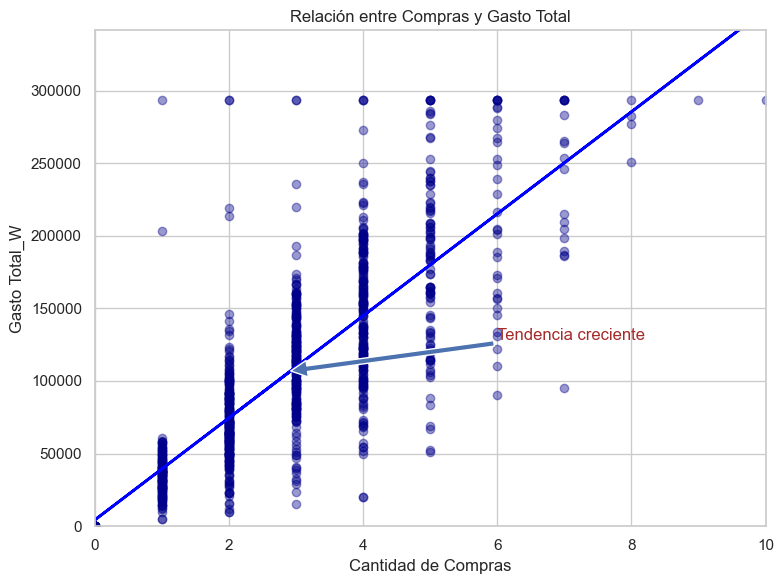

In [33]:
# ------- RELACION ESTRATÉGICA ------- #

fig, ax = plt.subplots(figsize=(8,6))

# Puntos 
ax.scatter(df_limpio["Compras"], df_limpio["Gasto_Total_W"], alpha=0.4, color="darkblue")

# Línea ajustada manual (modelo simple, grado 1, lineal)
coef = np.polyfit(df_limpio["Compras"], df_limpio["Gasto_Total_W"], 1)
poly1d_fn = np.poly1d(coef)

ax.plot(df_limpio["Compras"], poly1d_fn(df_limpio["Compras"]), linewidth=2, color="blue")
ax.set_title("Relación entre Compras y Gasto Total")
ax.set_xlabel("Cantidad de Compras")
ax.set_ylabel("Gasto Total_W")
ax.set_xlim(0, df_limpio["Compras"].max())
ax.set_ylim(0, df_limpio["Gasto_Total"].quantile(0.99))

# Anotación 
ax.annotate("Tendencia creciente",
    xy=(df_limpio["Compras"].mean(), df_limpio["Gasto_Total_W"].mean()),
    xytext=(6, df_limpio["Gasto_Total_W"].mean()*1.2),
    arrowprops=dict(), color="brown")

plt.tight_layout()
plt.savefig("regresion_compras_gasto.png")
plt.show()

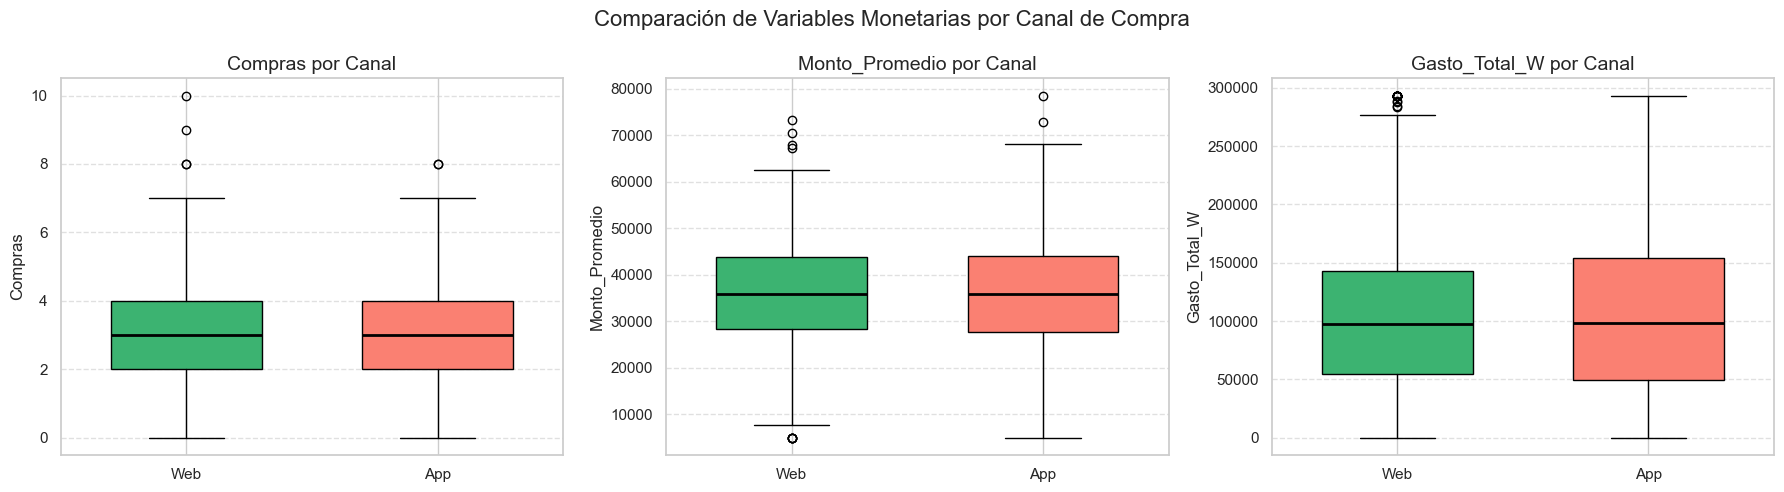

In [34]:
# -------- VARIABLES MONETARIAS POR CANAL --------- #

variables = ["Compras", "Monto_Promedio", "Gasto_Total_W"]

# 3 gráficos en una fila
fig, axs = plt.subplots(1, 3, figsize=(18,5))

for i, var in enumerate(variables):

    # Separar datos por canal
    web = df_limpio[df_limpio["Canal"] == "Web"][var]
    app = df_limpio[df_limpio["Canal"] == "App"][var]

    # Crear boxplot doble (Canal: Web y App)
    box = axs[i].boxplot([web, app], tick_labels=["Web", "App"], patch_artist=True, widths=0.6)

    # Colores personalizados
    colors = ["mediumseagreen", "salmon"] 
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Mediana más visible (para comparación)
    for median in box['medians']:
        median.set(color="black", linewidth=2)

    # Personalización
    axs[i].set_title(f"{var} por Canal", fontsize=14)
    axs[i].set_ylabel(var)
    axs[i].grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Comparación de Variables Monetarias por Canal de Compra", fontsize=16)
plt.tight_layout()
plt.savefig("boxplots_monetarios_por_canal.png", dpi=300)
plt.show()

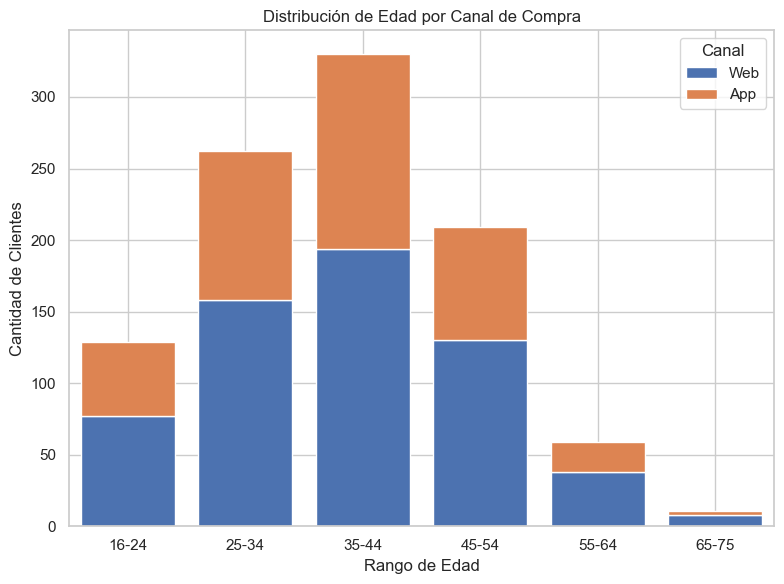

In [35]:
# -------- USO DE CANAL POR RANGO ETARIO -------- #

# Crear agrupaciones por edad
bins = [16, 25, 35, 45, 55, 65, 76]
labels = ["16-24", "25-34", "35-44", "45-54", "55-64", "65-75"]

df_limpio["Rango_Edad"] = pd.cut(df_limpio["Edad"], bins=bins, labels=labels, right=False)

tabla = pd.crosstab(df_limpio["Rango_Edad"], df_limpio["Canal"])
fig, ax = plt.subplots(figsize=(8,6))

# Valores
web = tabla["Web"]
app = tabla["App"]

# Posiciones
x = np.arange(len(tabla.index))

# Barras
ax.bar(x, web, label="Web")
ax.bar(x, app, bottom=web, label="App")

# Personalización
ax.set_xticks(x)
ax.set_xticklabels(tabla.index)
ax.set_title("Distribución de Edad por Canal de Compra")
ax.set_xlabel("Rango de Edad")
ax.set_ylabel("Cantidad de Clientes")
ax.set_xlim(-0.5, len(x)-0.5)
ax.legend(title="Canal")

plt.tight_layout()
plt.savefig("edad_por_canal_apilado.png", dpi=300)
plt.show()

El análisis sugiere que ambos canales cumplen funciones complementarias:
- App: potencialmente más atractiva para segmentos jóvenes y clientes de mayor gasto puntual.
- Web: canal estable con base amplia y comportamiento consistente.

In [37]:
# ------- ARCHIVO DE DATOS FINAL ------- #
df_limpio.to_csv('data_limpia.csv', index=False, encoding="utf-8-sig")

### Análisis Comercial Integrado

El análisis exploratorio permitió identificar patrones estructurales claros en el comportamiento de los clientes.

En primer lugar, la distribución etaria muestra una concentración predominante entre los 25 y 45 años, lo que indica que el público objetivo principal corresponde a adultos jóvenes y de mediana edad, segmento típicamente activo en comercio electrónico.

La relación entre compras y gasto total presenta una tendencia creciente fuerte y consistente, lo que confirma que el volumen de transacciones es el principal impulsor del ingreso total. Esto sugiere que las estrategias orientadas a incrementar la frecuencia de compra pueden tener un impacto directo y significativo en los ingresos.

A nivel regional, se observan diferencias moderadas en el gasto promedio, destacándose una región con mayor ticket promedio. Esto abre oportunidades de análisis más profundo para replicar estrategias exitosas en otras zonas o identificar factores socioeconómicos que expliquen dichas variaciones.

Finalmente, el análisis evidencia que las devoluciones impactan negativamente en los niveles de satisfacción. Los clientes con una o más devoluciones presentan una disminución clara en su calificación promedio, lo que resalta la importancia estratégica de optimizar procesos postventa y logística inversa para proteger la experiencia del cliente.

**Conclusión Estratégica**

El comportamiento de gasto está principalmente determinado por la frecuencia de compra, mientras que la satisfacción se ve afectada por la experiencia posterior a la venta. Esto sugiere que una estrategia integral debe enfocarse en:

- Incentivar recurrencia de compra
- Reducir devoluciones mediante mejoras operativas
- Analizar prácticas exitosas en regiones de alto rendimiento
- Segmentar campañas hacia el grupo etario predominante